In [85]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/2n")
dir = os.path.join(pickledir, "images_2n_wc_static_short")

print(dir)

def get_period(timeseries, dt):
    peaks = scipy.signal.find_peaks(timeseries, prominence=0.001)[0]
    periods = []
    for i in range(2, len(peaks)-1):
        periods.append( (peaks[i] - peaks[i-1]) * dt)
    return np.mean(periods)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/2n/images_2n_wc_static_short


In [86]:
p_names = ["D-exp", "D-osc", "U-exp", "U-osc", "Bi-exp", "Bi-osc"]
coords = [[1., 1.5], [1.5, 1.], [3., 1.], [2.2, 0.4], [2.2, 2.1], [2.4, 1.6]]

coupling = 1.8
cmat = np.array( [[0., 1.], [1., 0.]] )
N = cmat.shape[0]

for i in range(len(p_names)):
    p = p_names[i]
    data[p]["coordinates"] = coords[i]

D-exp
D-osc


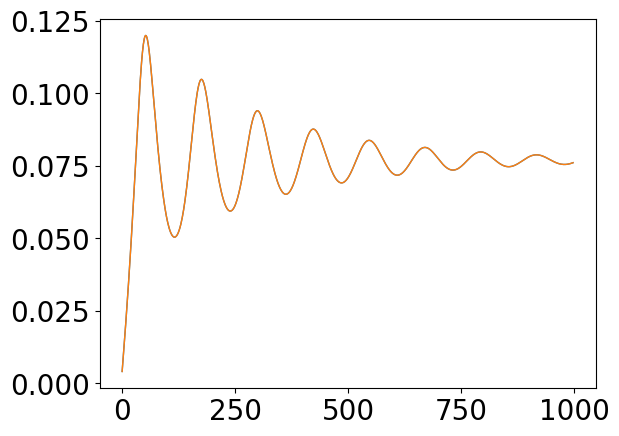

12.328571428571427 12.328571428571427
U-exp
U-osc


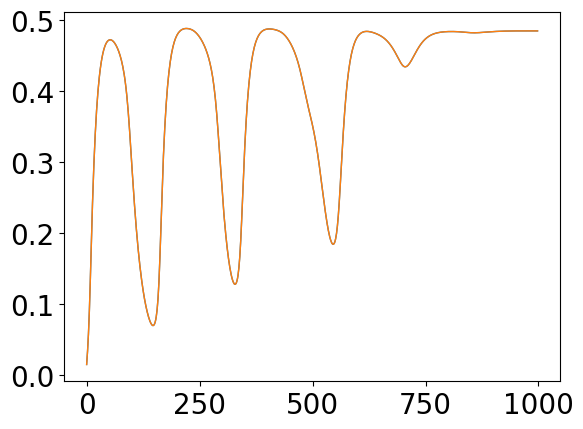

18.85 18.85
Bi-exp


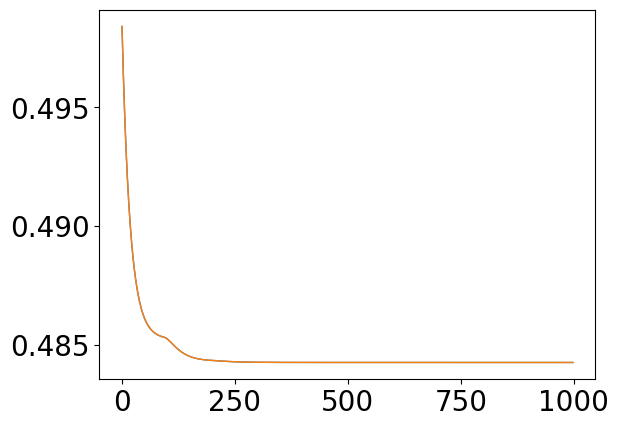

Bi-osc


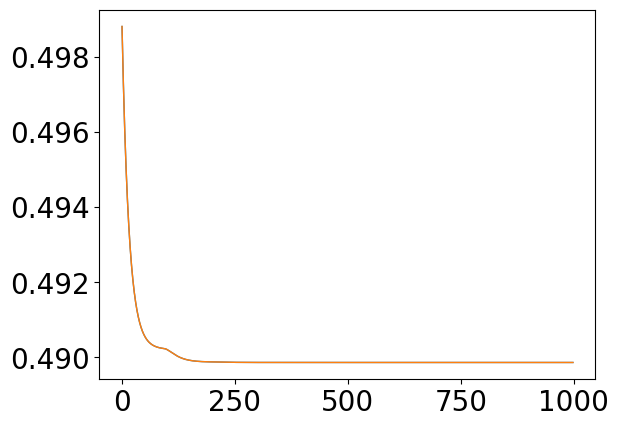

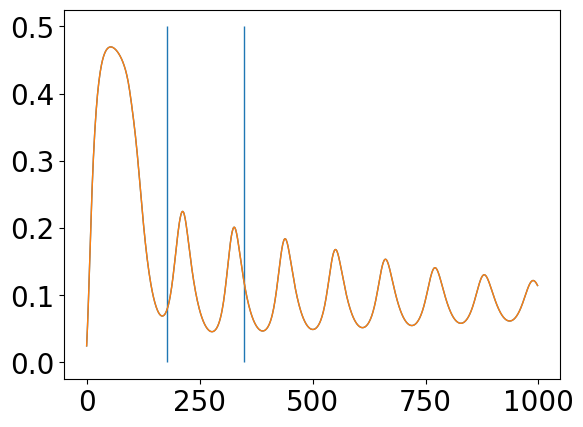

10.750000000000002


In [87]:
if True:
    data = dict()
    data_13 = dict()

    for i in range(len(p_names)):
        p = p_names[i]
        data[p] = dict()
        data[p]["coordinates"] = coords[i]
        data[p]["target_period"] = 20.
        data[p]["delay"] = 9.5

        data_13[p] = dict()



        if "Bi" in p:
            data[p]["control"] = [[None, None], [None, None]]
            data[p]["state"] = [[None, None], [None, None]]
            data[p]["init_state"] = [None, None]
            data[p]["weight"] = [[1., 1.], [1., 1.]]
            data[p]["dur/per"] = [[1000., 20], [1000., 20]]
        else:
            data[p]["control"] = [None, None]
            data[p]["state"] = [None, None]
            data[p]["init_state"] = None
            data[p]["weight"] = [5. * 1e-5, 5. * 1e-4]
            data[p]["dur/per"] = [340., 10]

            data_13[p]["control"] = [None for x0 in range(20)]
            data_13[p]["state"] = [None for x0 in range(20)]


duration = 2000.
dt = 0.1

data["U-osc"]["delay"] = 13.75
data["Bi-osc"]["delay"] = 9.5

test_input_plus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_plus[:,:500] = 5.

test_input_minus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_minus[:,:500] = -5.

for pi in range(len(p_names)):

    if "Bi" in p_names[pi]:
        continue

    print(p_names[pi])

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p_names[pi]]["coordinates"][0]
    model.params.inh_ext_baseline = data[p_names[pi]]["coordinates"][1]
    model.params["exc_ext"] = test_input_minus

    model.params.K_gl = coupling
    model.run()
    nmaxdelay = model.getMaxDelay()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"] = [einit, iinit]

    if "osc" in p_names[pi]:
        plt.plot(model.exc[0,501:1500])
        plt.plot(model.exc[1,501:1500])
        plt.show()

        per0 = get_period(-model.exc[0,601:], dt)
        per1 = get_period(-model.exc[1,601:], dt)
        data[p_names[pi]]["target_period"] = np.mean([per0, per1])

        print(per0, per1)        

for pi in range(len(p_names)):

    if "Bi" not in p_names[pi]:
        continue

    print(p_names[pi])

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p_names[pi]]["coordinates"][0]
    model.params.inh_ext_baseline = data[p_names[pi]]["coordinates"][1]
    model.params.K_gl = coupling
    nmaxdelay = model.getMaxDelay()

    model.params["exc_ext"] = test_input_plus
    model.params["inh_ext"] = test_input_plus
    model.run()

    plt.plot(model.exc[0,501:1500])
    plt.plot(model.exc[1,501:1500])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"][0] = [einit, iinit]

    model.params["exc_ext"] = test_input_minus
    model.params["inh_ext"] = test_input_minus
    model.run()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"][1] = [einit, iinit]

    if "osc" in p_names[pi]:
        plt.plot(model.exc[0,501:1500])
        plt.plot(model.exc[1,501:1500])
        plt.vlines([177, 348], 0, 0.5)
        plt.show()

        per0 = get_period(-model.exc[0,601:], dt)
        per1 = get_period(-model.exc[1,601:], dt)
        data[p_names[pi]]["target_period"] = np.mean([per0, per1])

        print(data[p]["target_period"])

In [88]:
controlmat = np.ones((N,2))

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

it = 50
maxstr = 5

pr = np.arange(0,1001,20)
testd = 1000.

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

In [89]:
def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

In [90]:
data["D-exp"]["weight"] = [5. * 1e-5, 5. * 1e-4]
data["D-osc"]["weight"] = [5. * 1e-5, 5. * 1e-4]
data["U-exp"]["weight"] = [5. * 1e-5, 5. * 1e-4]
data["U-osc"]["weight"] = [1. * 1e-6, 1. * 1e-5]

data["D-exp"]["dur/per"] = [340., 10]
data["D-osc"]["dur/per"] = [300., 10]
data["U-exp"]["dur/per"] = [340., 10]
data["U-osc"]["dur/per"] = [300., 10]

In [91]:
it = 10

for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi" in p:
        continue

    if pi not in [1,3]: continue

    print("Point ", p)
      
    target_period = data[p]["target_period"]

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    nmaxdelay = model.getMaxDelay()
    print("target period, max delay = ", target_period, nmaxdelay)

    model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
    model.params.K_gl = coupling
        
    model.params.duration = data[p]["dur/per"][0]
    print("duration = ", model.params.duration)

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data[p]["init_state"][0]
    model.params["inh_init"] = data[p]["init_state"][1]

    model.run()
    
    int0 = 400
    int1 = int0 + int(data[p]["dur/per"][1]*target_period/dt)

    for wi, w2 in enumerate(data[p]["weight"]):

        print("w2 = ",w2)

        for factor in [1]:
        #for factor in np.random.rand(2):

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(int0, int1), 
                                          cost_matrix=costmat, control_matrix=controlmat, )
            model_controlled.channelwise_optimization = True
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2 * factor
            model_controlled.weights["w_f_sync"] = 1. 

            model_controlled.maximum_control_strength = maxstr

            if True:
                if type(data[p]["control"][wi]) != type(None):
                    model_controlled.control = data[p]["control"][wi].copy()
                    model_controlled.update_input()
                else:
                    model_controlled.control +=1e-3
                    model_controlled.update_input()

            model_controlled.grad_method = 1
            model_controlled.channelwise_optimization = True

            for l in range(4):
                for k in np.arange(-12., 12., 2.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(it)

            data[p]["control"][wi] = model_controlled.control.copy()
            data[p]["state"][wi] = model_controlled.get_xs()

    plot_control(data[p], data[p]["dur/per"][0], dt, 0)
    plot_control(data[p], data[p]["dur/per"][0], dt, 1)

with open(os.path.join(pickledir, '2n_wc_static_short.pickle'), 'wb') as f:
    pickle.dump(data, f)

Point  D-osc
target period, max delay =  12.328571428571427 95
duration =  300.0
w2 =  5e-05
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 1.2317057224138752e-08
Final cost : 1.2314807283939223e-08
Compute control for a deterministic system
Cost in iteration 0: 1.2314807283939223e-08


KeyboardInterrupt: 

In [ ]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi" in p:
        continue

    if pi not in [1,3]:
        continue

    print("Point ", p)   

    for wi in range(len(data[p]["weight"])):

        print(data[p]["weight"][wi])

        filename = os.path.join(dir, str(p) + "_" + str(wi) + ".png")
        title = "WC " + p + r" $\rightarrow$ osc, $w_2 = $ " + "{}".format(data[p]["weight"][wi])
        plot_control(data[p],  data[p]["dur/per"][0], dt, wi, filename=filename, title=title)

Point  D-osc


KeyError: 'D-osc'

In [ ]:
data_13 = data.copy()

In [ ]:
it = 10

for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi" in p:
        continue

    if pi not in [1]: continue

    print("Point ", p)

    for fi, factor in enumerate(np.arange(0.4, 2.4, 0.1)):
      
        target_period = data[p]["target_period"] * factor

        model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
        nmaxdelay = model.getMaxDelay()
        print("target period, factor, max delay = ", target_period, factor,nmaxdelay)

        model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
        model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
        model.params.K_gl = coupling

        int0 = 100
        int1 = int0 + int(data[p]["dur/per"][1]*target_period/dt)
            
        model.params.duration = int1 * dt
        print("duration = ", model.params.duration)

        zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
        zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
        zero_control = np.vstack( ([zero_input]*N))
        zero_control = np.vstack( ([zero_input]*N))
        model.params["exc_ext"] = zero_control[:,0,:]
        model.params["inh_ext"] = zero_control[:,1,:]

        model.params["exc_init"] = data[p]["init_state"][0]
        model.params["inh_init"] = data[p]["init_state"][1]

        model.run()

        w2 = 1e-4
        print("w2 = ",w2)

        for fac_w in [1]:
        #for factor in np.random.rand(2):

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(int0, None), 
                                        cost_matrix=costmat, control_matrix=controlmat, )
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2 * fac_w
            model_controlled.weights["w_f_sync"] = 1. 

            model_controlled.maximum_control_strength = maxstr

            if True:
                if type(data_13[p]["control"][fi]) != type(None):
                    model_controlled.control = data_13[p]["control"][fi].copy()
                    model_controlled.update_input()
                else:
                    model_controlled.control +=1e-3
                    model_controlled.update_input()

            model_controlled.control +=1e-1
            model_controlled.update_input()

            model_controlled.grad_method = 1
            model_controlled.channelwise_optimization = True

            for l in range(1):
                for k in np.arange(-0., 12., 2.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(it)

            data_13[p]["control"][fi] = model_controlled.control.copy()
            data_13[p]["state"][fi] = model_controlled.get_xs()

        #plot_control_freq(data_13[p], model_controlled.model.params.duration, dt, fi)

Point  D-osc
target period, factor, max delay =  16.027142857142856 0.4 95
duration =  170.20000000000002
w2 =  0.0001
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.052808309274158714
Converged in iteration 2 with cost -0.052836480157477245
Final cost : -0.052836480157477245
Compute control for a deterministic system
Cost in iteration 0: -0.052836480157477245
Converged in iteration 5 with cost -0.05283648015747735
Final cost : -0.05283648015747735
Compute control for a deterministic system
Cost in iteration 0: -0.05283648015747735
Final cost : -0.05283648016083441
Compute control for a deterministic system
Cost in iteration 0: -0.05283648016083441
Final cost : -0.0528364804965634
Compute control for a deterministic system
Cost in iteration 0: -0.0528364804965634
Final cost : -0.052836514067840394
Compute control for a deterministic system
Cost in iteration 0: -0.052836514067840394
Final cost : -0.05283985510490439
Comp

KeyboardInterrupt: 

Point  D-osc
Point  U-osc


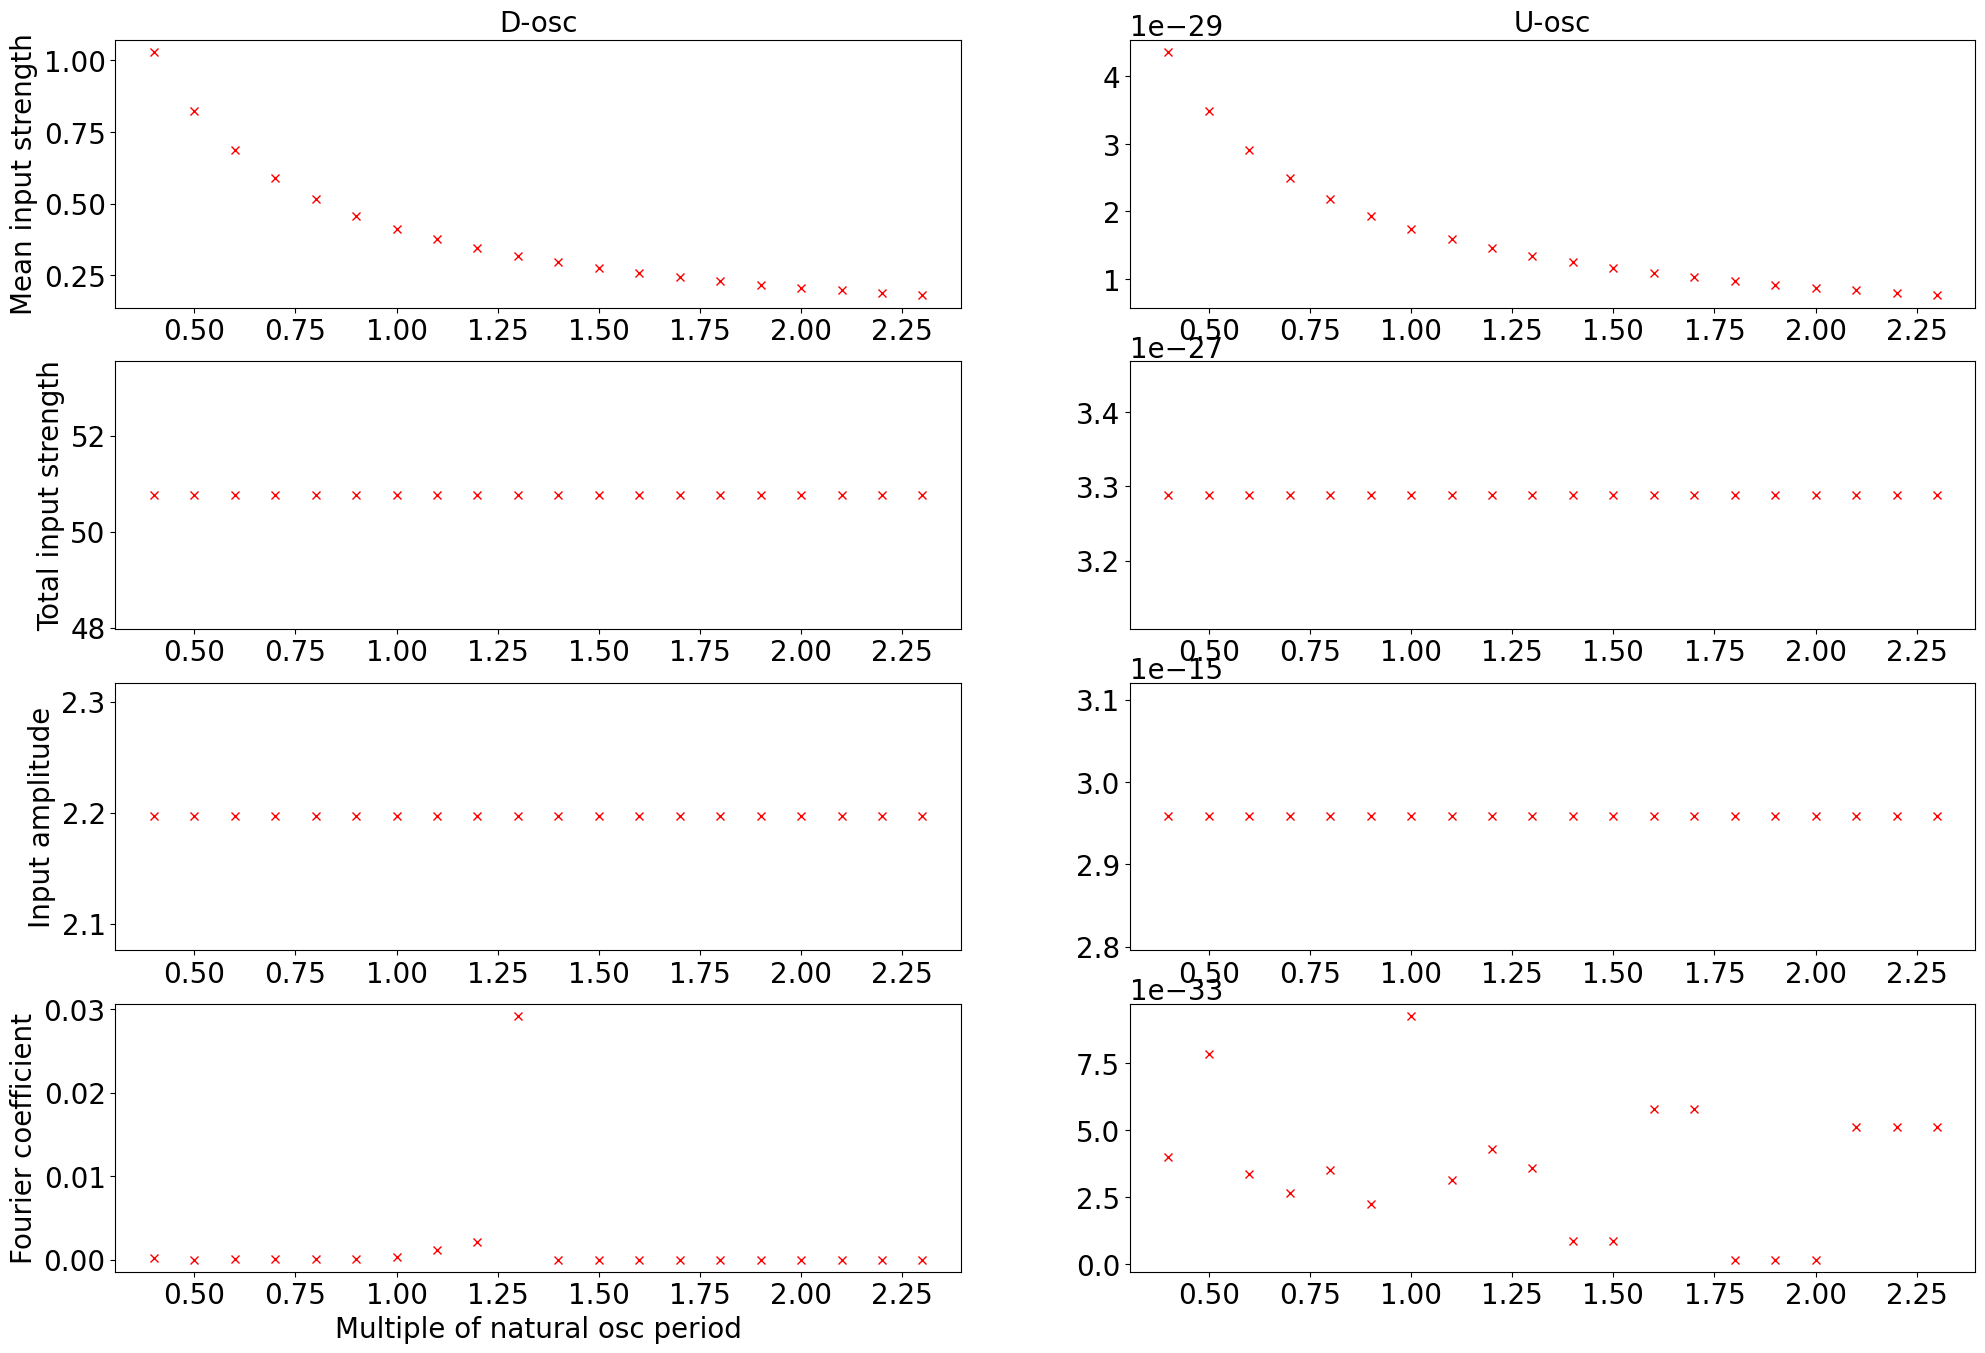

In [ ]:
fig,ax = plt.subplots(4,2, figsize=(24,16))

ax[0,0].set_ylabel("Mean input strength")
ax[1,0].set_ylabel("Total input strength")
ax[2,0].set_ylabel("Input amplitude")
ax[3,0].set_ylabel("Fourier coefficient")
ax[-1,0].set_xlabel("Multiple of natural osc period")

for pi in range(len(p_names)):
    p = p_names[pi]

    if pi not in [1,3]:
        continue

    print("Point ", p)  

    colind = 0
    if pi == 3: colind = 1

    ax[0,colind].set_title(p_names[pi])

    for fi, factor in enumerate(np.arange(0.4, 2.4, 0.1)):

        target_period = data[p]["target_period"] * factor
        int0 = 100
        int1 = int0 + int(data[p]["dur/per"][1]*target_period/dt)
        dur = (int1-int0)*dt

        fcost = - np.sum(np.sum(cost_functions.fourier_cost(data_13[p]["state"][fi], dt, target_period, costmat, [int0, int1]), axis=0), axis=0)
        ucost = np.sum(np.sum(np.sum(cost_functions.L2_cost(data_13[p]["control"][fi]), axis=0), axis=0), axis=0)*dt
        amp = np.amax(np.abs(data_13[p]["control"][fi]))

        ax[0, colind].plot(factor, ucost/dur, color="red", marker="x")
        ax[1, colind].plot(factor, ucost, color="red", marker="x")
        ax[2, colind].plot(factor, amp, color="red", marker="x")
        ax[3, colind].plot(factor, fcost, color="red", marker="x")

plt.show()

In [ ]:
y0lim = [0, 0.6]

def plot_control(data, dur, dt, wi, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(24,10), sharex="col", sharey="row")
    time_array = np.arange(0, dur+dt, dt)

    cmin = min( np.amin(data["control"][0]) , np.amin(data["control"][1]) )
    cmax = max( np.amax(data["control"][0]) , np.amax(data["control"][1]) )
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0, n].plot(time_array, data["state"][wi][n,0,:], color="red", label="E")
        ax[0, n].plot(time_array, data["state"][wi][n,1,:], color="blue", label="I")
        ax[1, n].plot(time_array, data["control"][wi][n,0,:], color="red", label="E")
        ax[1, n].plot(time_array, data["control"][wi][n,1,:], color="blue", label="I")

    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(0, dur)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0")
    ax[0,1].set_title("n=1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

def plot_control_freq(data, dur, dt, fi, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(12,6), sharex="col", sharey="row")
    time_array = np.arange(0, dur+dt, dt)

    cmin = np.amin(data["control"][fi])
    cmax = np.amax(data["control"][fi])
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0, n].plot(time_array, data["state"][fi][n,0,:], color="red", label="E")
        ax[0, n].plot(time_array, data["state"][fi][n,1,:], color="blue", label="I")
        ax[1, n].plot(time_array, data["control"][fi][n,0,:], color="red", label="E")
        ax[1, n].plot(time_array, data["control"][fi][n,1,:], color="blue", label="I")

    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(0, dur)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0")
    ax[0,1].set_title("n=1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return


def plot_control_bi(data, dur, dt, wi, iinit, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(24,10), sharex="col", sharey="row")
    time_array = np.arange(0, dur+dt, dt)

    cmax = max( np.amax(np.abs(data["control"][iinit][0])), np.amax(np.abs(data["control"][iinit][1])) )
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0, n].plot(time_array, data["state"][iinit][wi][n,0,:], color="red", label="E")
        ax[0, n].plot(time_array, data["state"][iinit][wi][n,1,:], color="blue", label="I")
        ax[1, n].plot(time_array, data["control"][iinit][wi][n,0,:], color="red", label="E")
        ax[1, n].plot(time_array, data["control"][iinit][wi][n,1,:], color="blue", label="I")

    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(0, dur)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0")
    ax[0,1].set_title("n=1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [ ]:
with open(os.path.join(pickledir, '2n_wc_static_short.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [ ]:
with open(os.path.join(pickledir, '2n_wc_static_short.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['D-exp', 'D-osc', 'U-exp', 'U-osc', 'Bi-exp', 'Bi-osc'])


In [94]:
data["Bi-exp"]["weight"] = [[1. * 1e-5, 1. * 1e-4], [1. * 1e-5, 1. * 1e-4]]
data["Bi-osc"]["weight"] = [[1. * 1e-5, 5. * 1e-4], [1. * 1e-5, 1. * 1e-4]]

data["Bi-exp"]["dur/per"] = [[500., 10], [500., 10]]
data["Bi-osc"]["dur/per"] = [[340., 10], [340., 10]]

Point  Bi-osc
target period, max delay =  10.750000000000002 95
duration =  340.0
w2 =  1e-05
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.0028136710194201463
Converged in iteration 4 with cost -0.0028136710194201463
Final cost : -0.0028136710194201463
Compute control for a deterministic system
Cost in iteration 0: -0.0028136710194201463
Cost in iteration 20: -0.00281367346772548
Converged in iteration 25 with cost -0.002816804420563748
Final cost : -0.002816804420563748
Compute control for a deterministic system
Cost in iteration 0: -0.002816804420563748
Cost in iteration 20: -0.0028249823925275887
Converged in iteration 24 with cost -0.002825028544101372
Final cost : -0.002825028544101372
Compute control for a deterministic system
Cost in iteration 0: -0.002825028544101372
Converged in iteration 7 with cost -0.0028250343688518255
Final cost : -0.0028250343688518255
Compute control for a deterministic system
Cost in 

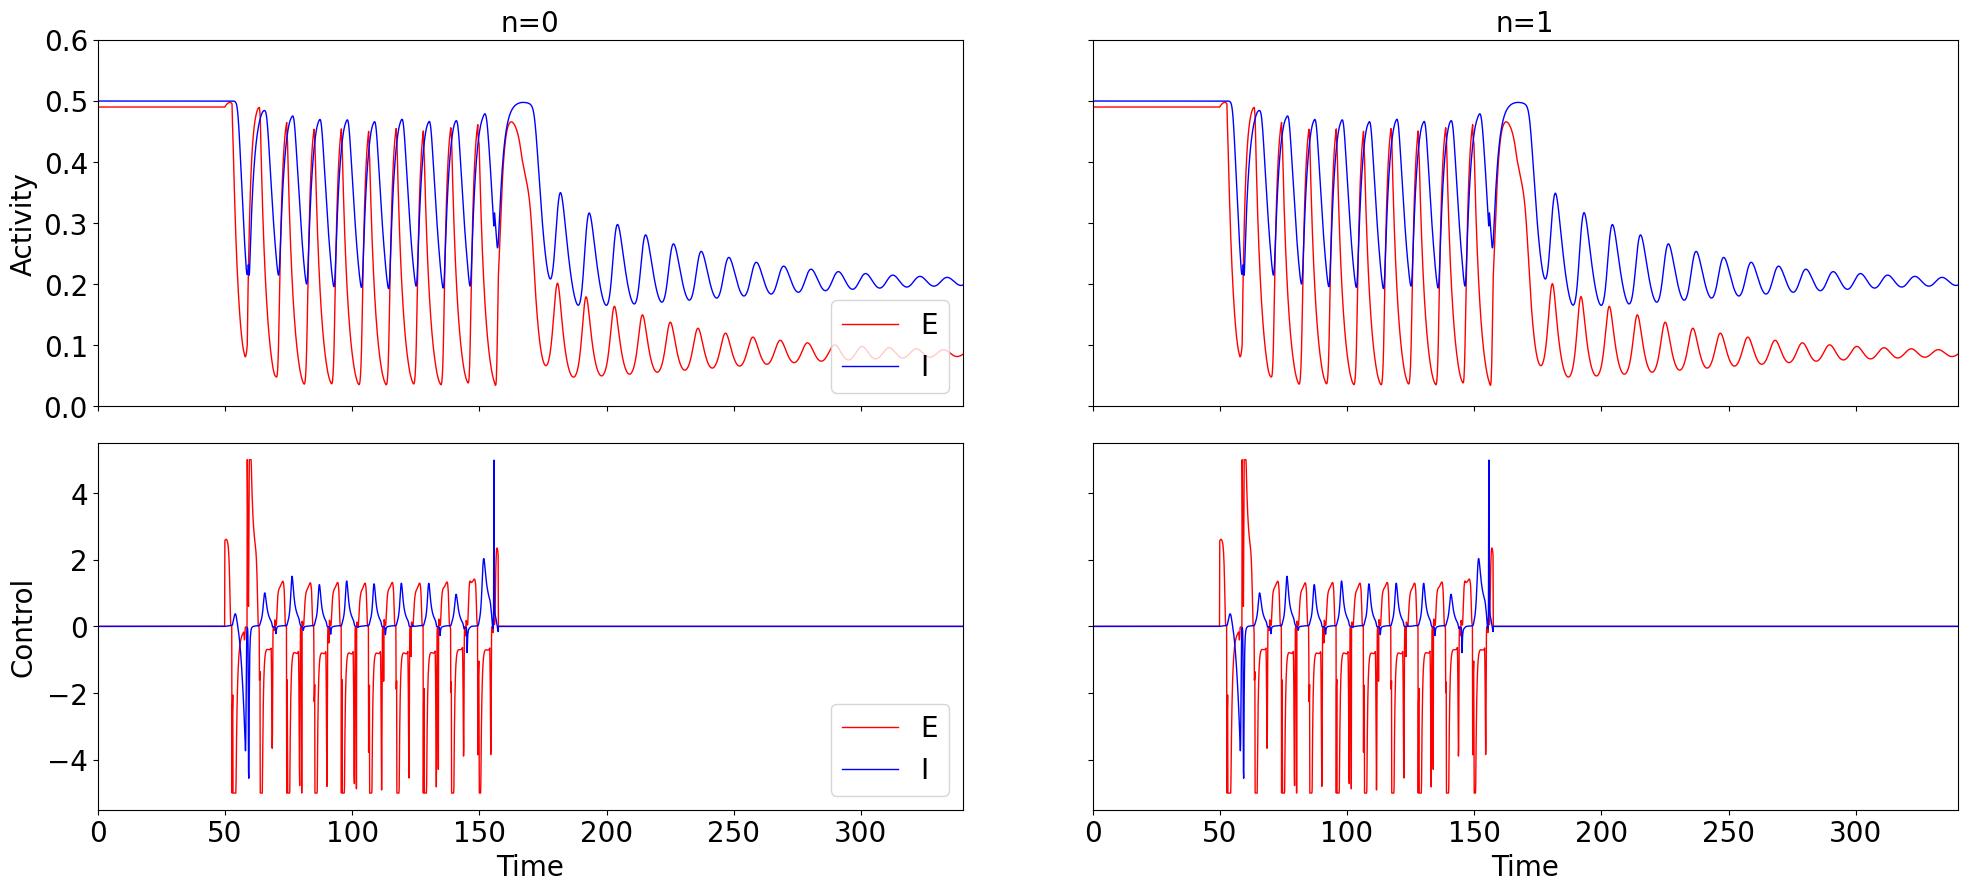

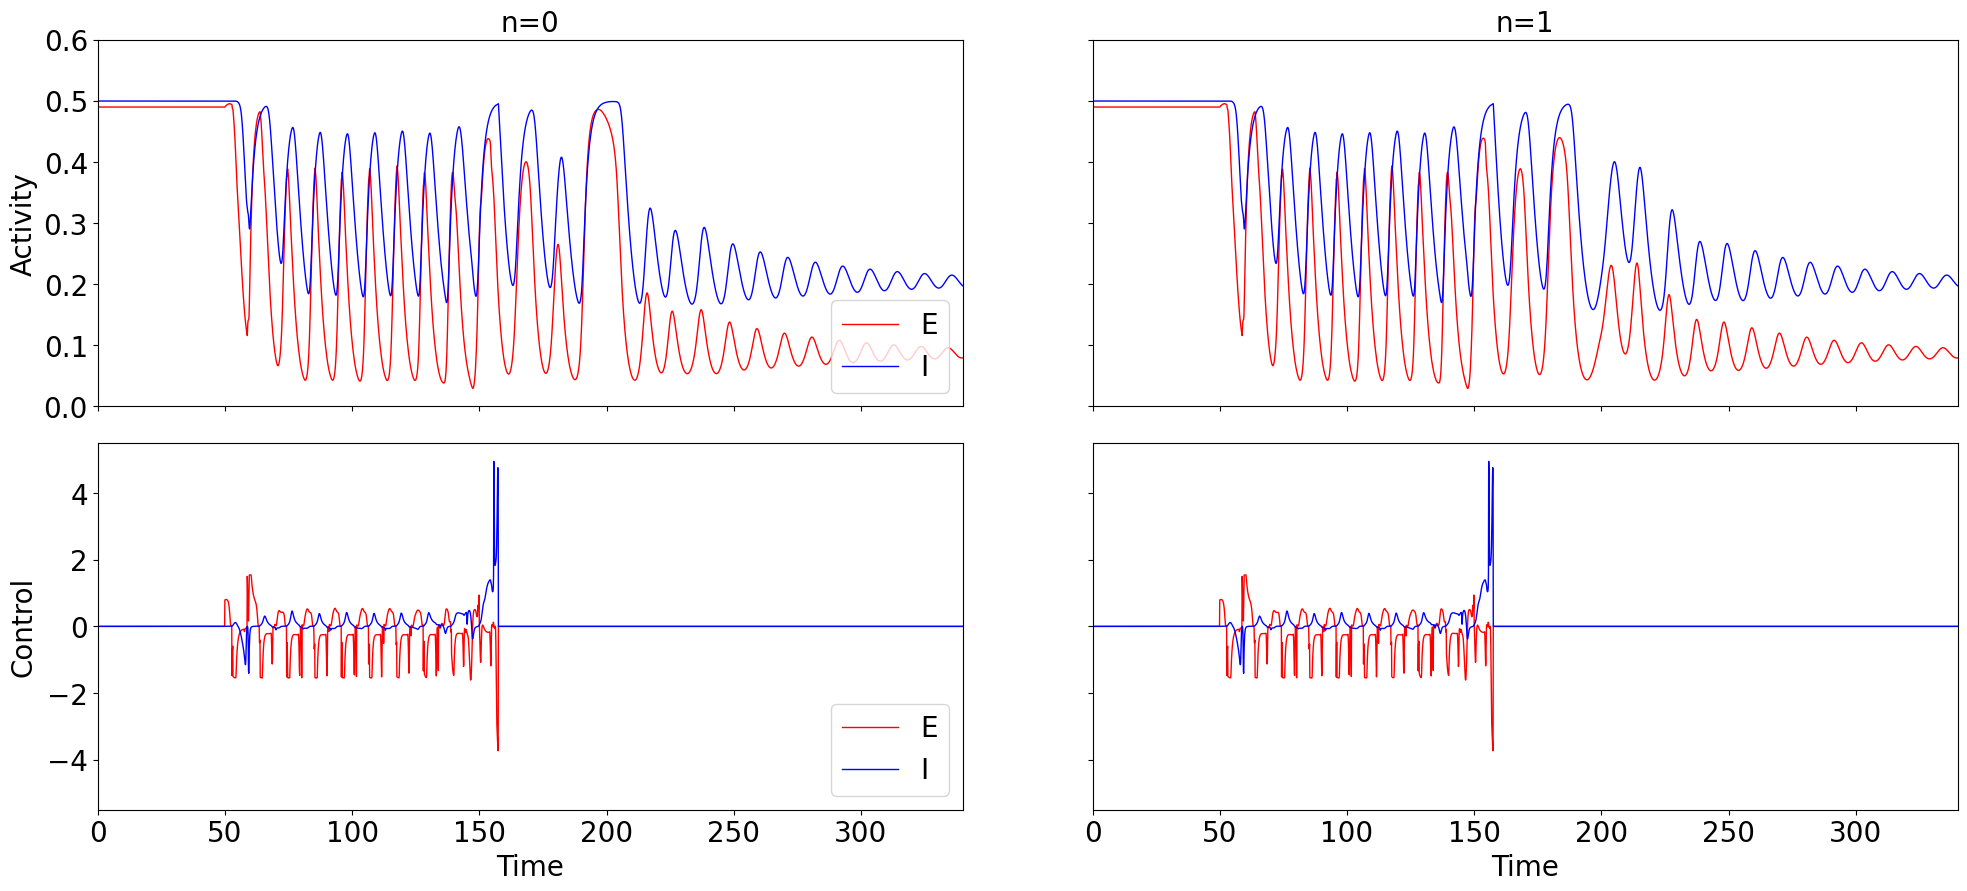

duration =  340.0
w2 =  1e-05
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.00810014298857459
Converged in iteration 5 with cost -0.00810014298857459
Final cost : -0.00810014298857459
Compute control for a deterministic system
Cost in iteration 0: -0.00810014298857459
Cost in iteration 20: -0.008100143015621411
Converged in iteration 35 with cost -0.008100165570527174
Final cost : -0.008100165570527174
Compute control for a deterministic system
Cost in iteration 0: -0.008100165570527174
Cost in iteration 20: -0.00810016742103853
Converged in iteration 27 with cost -0.008100173712483907
Final cost : -0.008100173712483907
Compute control for a deterministic system
Cost in iteration 0: -0.008100173712483907
Converged in iteration 19 with cost -0.008100184084478919
Final cost : -0.008100184084478919
Compute control for a deterministic system
Cost in iteration 0: -0.008100184084478919
Converged in iteration 5 with cost -0.0

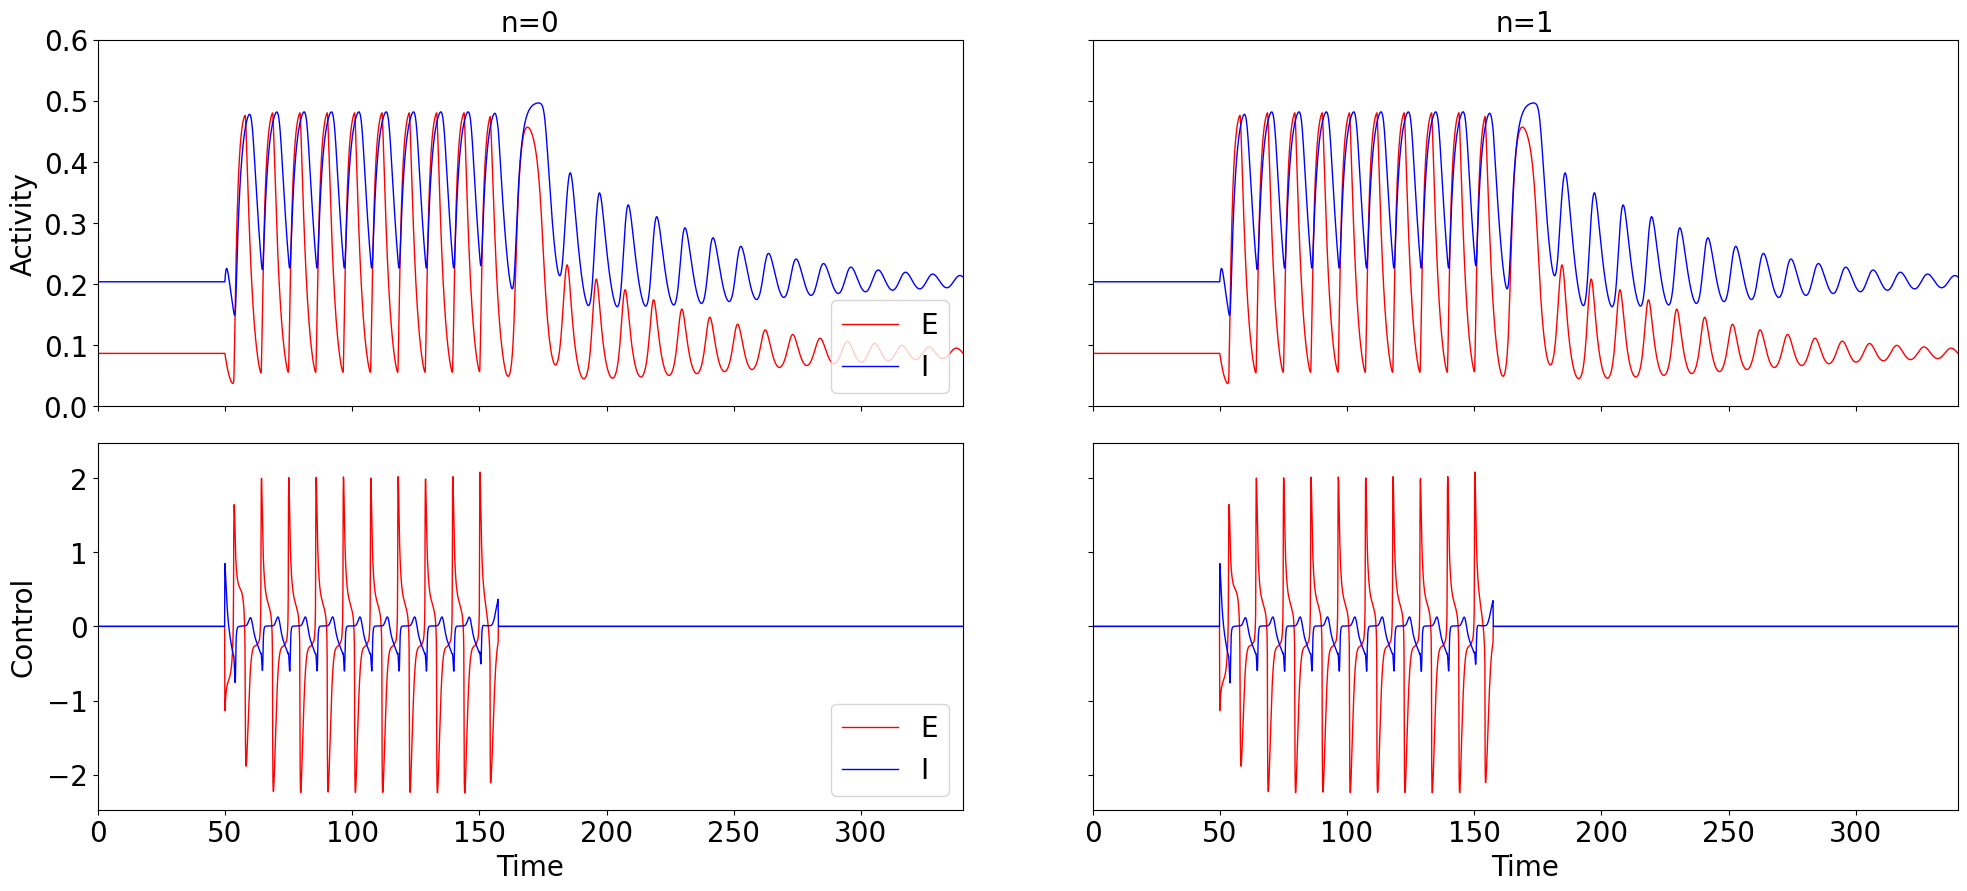

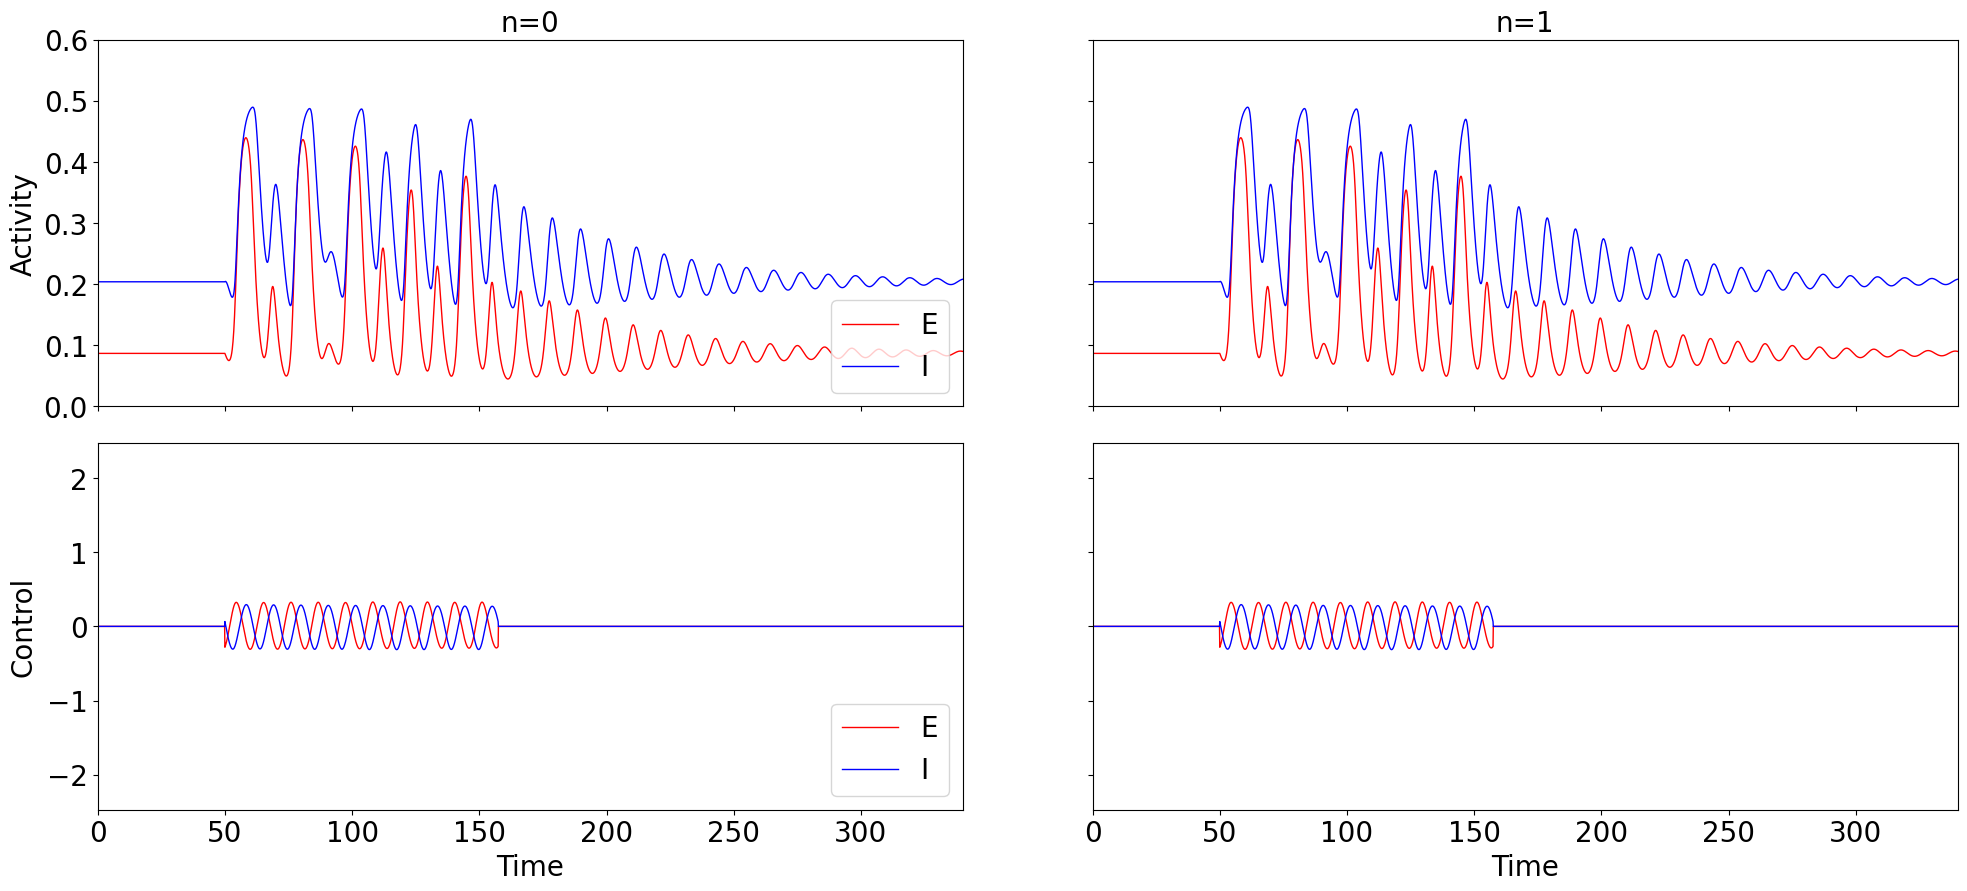

In [124]:
it = 100

for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi" not in p:
        continue

    if pi not in [5]: continue

    print("Point ", p)

    target_period = data[p]["target_period"]

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    nmaxdelay = model.getMaxDelay()
    print("target period, max delay = ", target_period, nmaxdelay)

    model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
    model.params.K_gl = coupling

    for i_init in range(2):
        
        model.params.duration = data[p]["dur/per"][i_init][0]
        print("duration = ", model.params.duration)

        zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
        zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
        zero_control = np.vstack( ([zero_input]*N))
        zero_control = np.vstack( ([zero_input]*N))
        model.params["exc_ext"] = zero_control[:,0,:]
        model.params["inh_ext"] = zero_control[:,1,:]

        model.params["exc_init"] = data[p]["init_state"][i_init][0]
        model.params["inh_init"] = data[p]["init_state"][i_init][1]

        model.run()
        
        int0 = 500
        int1 = int0 + int(data[p]["dur/per"][i_init][1]*target_period/dt)

        for wi, w2 in enumerate(data[p]["weight"][i_init]):

            print("w2 = ",w2)

            #if wi in [0]: continue
            #if i_init in [1]: continue

            for factor in [1]:
            #for factor in np.random.random(3):

                model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
                model_controlled.weights["w_p"] = 0.
                model_controlled.weights["w_2"] = w2 * factor
                model_controlled.weights["w_f_sync"] = 1.

                model_controlled.maximum_control_strength = maxstr

                if True:
                    if type(data[p]["control"][i_init][wi]) != type(None):
                        model_controlled.control = data[p]["control"][i_init][wi].copy()
                        model_controlled.update_input()    
                    else:
                        model_controlled.control += 1e-3
                        model_controlled.update_input()

                #model_controlled.grad_method = 1
                model_controlled.channelwise_optimization = True

                for l in range(1):
                    for k in np.arange(-8., 8., 2.):
                        model_controlled.zero_step_encountered = False
                        model_controlled.step = 10**(k)
                        model_controlled.optimize(it)

                data[p]["control"][i_init][wi] = model_controlled.control.copy()
                data[p]["state"][i_init][wi] = model_controlled.get_xs()
                                       
        plot_control_bi(data[p], data[p]["dur/per"][i_init][0], dt, 0, i_init)
        plot_control_bi(data[p], data[p]["dur/per"][i_init][0], dt, 1, i_init)

with open(os.path.join(pickledir, '2n_wc_static_short.pickle'), 'wb') as f:
    pickle.dump(data, f)

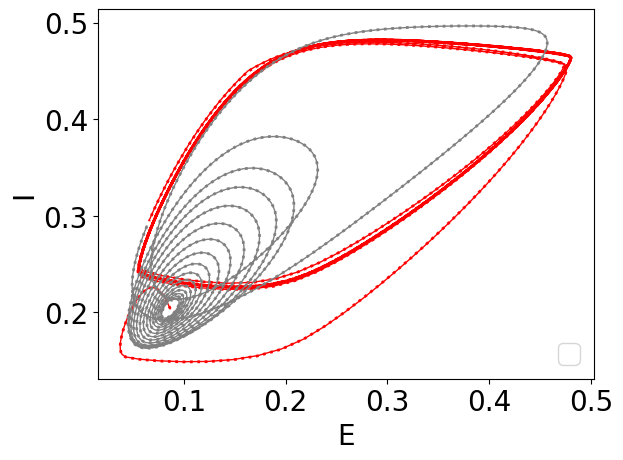

In [123]:
state = data["Bi-osc"]["state"][1][0]

i0 = 500
i1 = 1600

plt.plot(state[0,0,i0:i1], state[0,1,i0:i1], color="red", linewidth=1)
plt.plot(state[1,0,i0:i1], state[1,1,i0:i1], color="red", linestyle=":", linewidth=2,)

plt.plot(state[0,0,i1:], state[0,1,i1:], color="gray", linewidth=1)
plt.plot(state[1,0,i1:], state[1,1,i1:], color="gray", linestyle=":", linewidth=2)

plt.xlabel("E")
plt.ylabel("I")

plt.legend(loc="lower right")
plt.savefig(os.path.join(dir, "EI_trajectory.png"))
plt.show()

Point  Bi-exp
0 1.0
None


TypeError: bad operand type for abs(): 'NoneType'

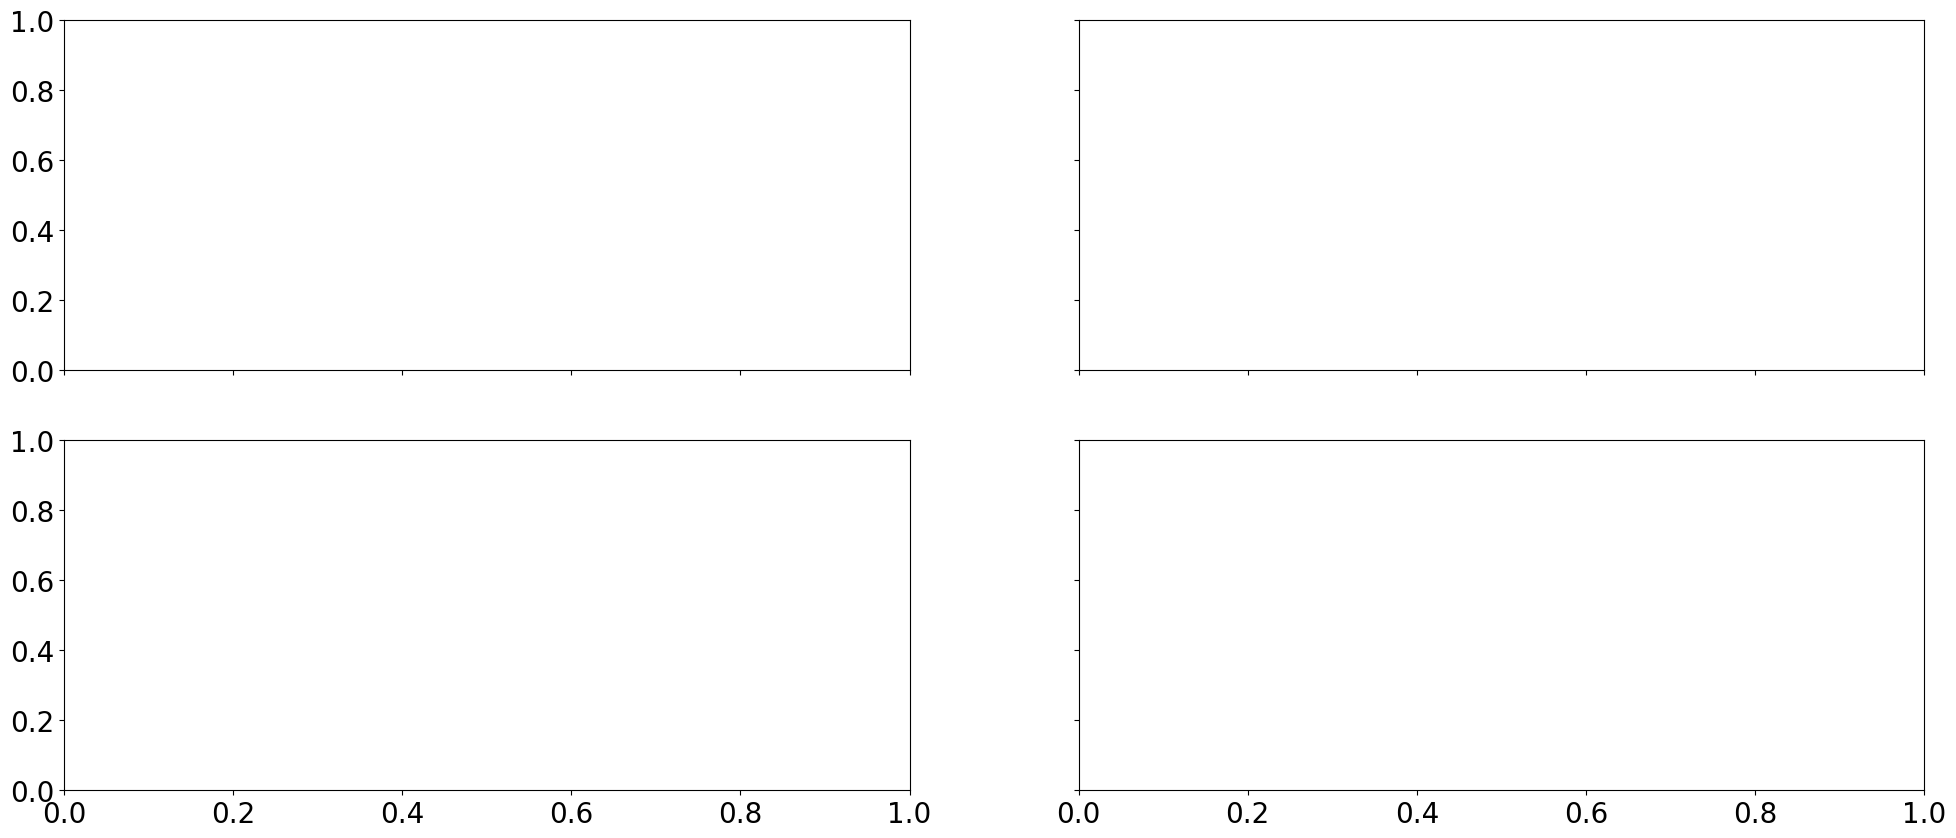

In [ ]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi" not in p:
        continue

    print("Point ", p)   

    for i_init in range(2):

        for wi in range(len(data[p]["weight"])):

            print(i_init, data[p]["weight"][i_init][wi])

            filename = os.path.join(dir, str(p) + "_" + str(i_init) + "_" + str(wi) + ".png")
            title = "WC " + p + r" $\rightarrow$ osc, $w_2 = $ " + "{}".format(data[p]["weight"][i_init][wi])
            plot_control_bi(data[p],  data[p]["dur/per"][i_init][0], dt, wi, i_init, filename=filename, title=title)